In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
import spacy
from unidecode import unidecode
import re
import string
import math
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats

In [2]:
caminho_arquivo = 'dataset/SMSSpamCollection'
colunas = ['Tipo', 'Mensagem']

#carregar aquivo para df pandas
df = pd.read_csv(caminho_arquivo, sep='\t', header=None, names=colunas)

df.head()

,Tipo,Mensagem
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)

df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


# **Analise**

Quantidade de SMS no df: 5572


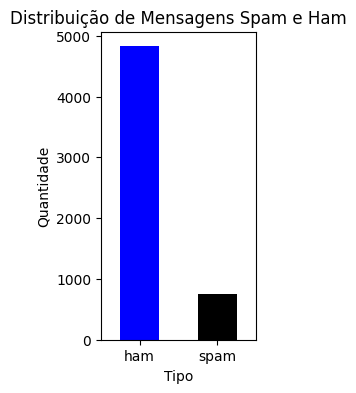

Quantidade de Ham: 4825
Quantidade de Spam: 747


In [4]:
print("Quantidade de SMS no df:", df.shape[0])

contagem_tipo = df['Tipo'].value_counts()

#grafico de barras
plt.figure(figsize=(2,4))
contagem_tipo.plot(kind='bar', color=['blue', 'black'])
plt.title('Distribuição de Mensagens Spam e Ham')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

print("Quantidade de Ham:", contagem_tipo['ham'])
print("Quantidade de Spam:", contagem_tipo['spam'])

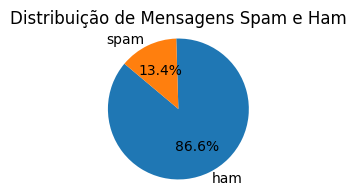

In [5]:
plt.figure(figsize=(2,2))
plt.pie(contagem_tipo, labels=contagem_tipo.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição de Mensagens Spam e Ham')
plt.axis('equal')
plt.show()

In [6]:
#separar os df em spam e ham
df_spam = df[df['Tipo'] == 'spam']
df_ham = df[df['Tipo'] == 'ham']

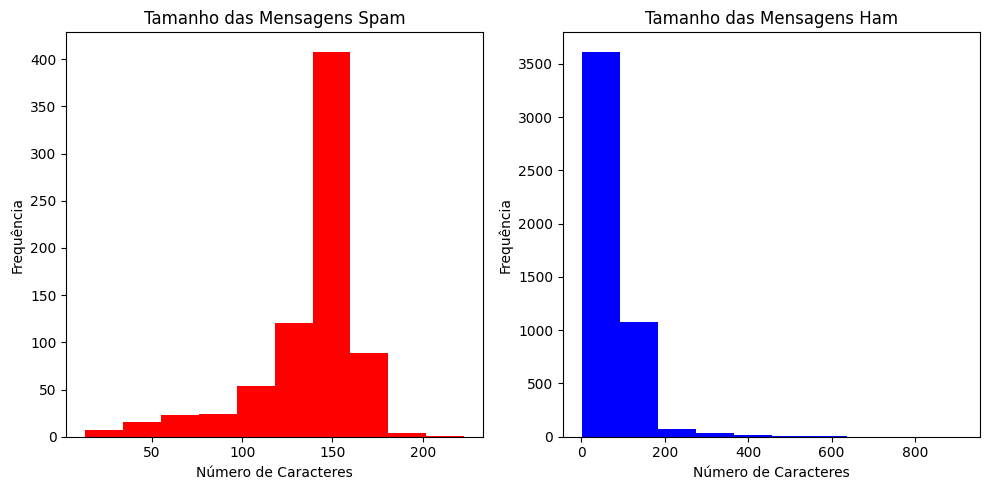

In [7]:
#plot do tamanho das mensagem por tipo
plt.figure(figsize=(10,5))

#hist do tamanho das mensagens spam
plt.subplot(1,2,1)
plt.hist(df_spam['Tamanho'], color='red', alpha=1)
plt.title('Tamanho das Mensagens Spam')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')

#hist do tamanho das mensagens
plt.subplot(1,2,2)
plt.hist(df_ham['Tamanho'], color='blue', alpha=1)
plt.title('Tamanho das Mensagens Ham')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


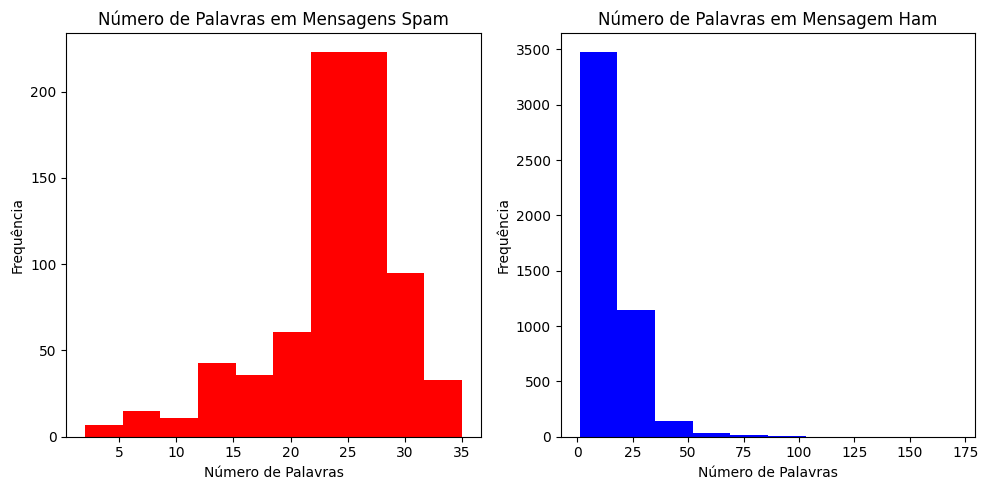

In [8]:
#plot o número de palavras por tipo
plt.figure(figsize=(10,5))

#hist do número de palavras spam
plt.subplot(1,2,1)
plt.hist(df_spam['N_Palavras'], color='red', alpha=1)
plt.title('Número de Palavras em Mensagens Spam')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')

#hist do número de palavras ham
plt.subplot(1,2,2)
plt.hist(df_ham['N_Palavras'], color='blue', alpha=1)
plt.title('Número de Palavras em Mensagem Ham')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

# **Pré-processamento**

## *1 - Normalização, remoção de acentos e stopwords*

In [9]:
#normaliza para minusculo
df['Mensagem'] = df['Mensagem'].str.lower()

#remove acentos
df['Mensagem'] = df['Mensagem'].apply(lambda x: unidecode(x))

#carregar o modelo spaCy para ingles
nlp = spacy.load('en_core_web_sm')

#funcao para remover stopword
def remove_stopword(text):
    doc = nlp(text)
    tokens_sem_stopword = [token.text for token in doc if not token.is_stop] #romove stopwords
    return ' '.join(tokens_sem_stopword) #recria a mensagem sem stopword

df['Mensagem'] = df['Mensagem'].apply(remove_stopword)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",92,19
1,ham,ok lar ... joking wif u oni ...,31,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor ... u c ...,27,8
4,ham,"nah think goes usf , lives",26,6


## *2 - Remove marcações e referencias de usuário*

In [10]:
#funcao para remover hashtags e referencias de usuario
def remove_tags_user(text):
    texto_sem_tag_user = re.sub(r'@[^\s]+|#[^\s]+', '', text) #[^\s]+ procura mais caracteres que n é o espaço
    return texto_sem_tag_user

#aplica a funcao na coluna mensagem
df['Mensagem'] = df['Mensagem'].apply(remove_tags_user)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",92,19
1,ham,ok lar ... joking wif u oni ...,31,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor ... u c ...,27,8
4,ham,"nah think goes usf , lives",26,6


## *3 - Reduz possiveis repetições*

In [11]:
#funcao para reduzir repeticoes
def reduz_repeticao(text):
    return re.sub(r'(.)\1+', r'\1\1', text)#(.)\1+ procura por qualquer caractere seguido pelo menos uma repetição, r'\1\1 substiu essa sequencia por duas ocorrencias do caractere

df['Mensagem'] = df['Mensagem'].apply(reduz_repeticao)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",90,19
1,ham,ok lar .. joking wif u oni ..,29,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor .. u c ..,25,8
4,ham,"nah think goes usf , lives",26,6


## *4 - Remove urls com formato www https*

In [12]:
#funcao para remover urls
def remove_urls(text):
    return re.sub(r'\b(?:https?://|www\.)\S+\b', '', text) #substitui qualquer sequencia que começa com https:// ou www. até achar um caractere em branco

df['Mensagem'] = df['Mensagem'].apply(remove_urls)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",90,19
1,ham,ok lar .. joking wif u oni ..,29,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor .. u c ..,25,8
4,ham,"nah think goes usf , lives",26,6


## *5 - Remove pontuações*

In [13]:
#Funcao parar remover pontuacao
def remove_pontuacao(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['Mensagem'] = df['Mensagem'].apply(remove_pontuacao)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis n great w...,83,15
1,ham,ok lar joking wif u oni,25,6
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,130,22
3,ham,u dun early hor u c,21,6
4,ham,nah think goes usf lives,25,5


## *6 - Remover entidades referentes a localização e organização utilizando spaCy*

In [14]:
#funcao para remover entidadesde localizacao e organizacao
def remove_loc_org(text):
    doc = nlp(text)
    texto_limpo = ' '.join([token.text if token.ent_type_ not in ['LOC', 'ORG'] else '' for token in doc])#se a entidade tokne.ent_type_ n for de LOC(localizacao) ou ORG(organizacao) o texto do token é mantido, se n vira uma string vazia
    return texto_limpo.strip()

df['Mensagem'] = df['Mensagem'].apply(remove_loc_org)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis n great...,85,15
1,ham,ok lar joking wif u oni,25,6
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,131,22
3,ham,u dun early hor u c,21,6
4,ham,nah think goes usf lives,26,5


## *7 - Remover tokens numericos*

In [15]:
#funcao para remover tokens numericos
def remove_tokens_num(text):
    return re.sub(r'\b\w*\d\w*\b', '', text)#\b fronteira de palavra, \w* zero ou mais caracteres de palavra, \d qualquer digito, removendo palavra que contenham número 

df['Mensagem'] = df['Mensagem'].apply(remove_tokens_num)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()


,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis n great...,85,15
1,ham,ok lar joking wif u oni,25,6
2,spam,free entry wkly comp win fa cup final tkts ...,100,17
3,ham,u dun early hor u c,21,6
4,ham,nah think goes usf lives,26,5


## *8 - Remover palavras com menos de 3 caracteres*

In [16]:
#funcao para remover palavras com menos de 3 caracteres
def remove_palavras_pequenas(text):
    return re.sub(r'\b\w{1,2}\b', '', text)#\w{1,2} encontra palavras que tem de 1 a 2 caracteres

df['Mensagem'] = df['Mensagem'].apply(remove_palavras_pequenas)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()


,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis great ...,81,12
1,ham,lar joking wif oni,22,4
2,spam,free entry wkly comp win cup final tkts ...,96,15
3,ham,dun early hor,18,3
4,ham,nah think goes usf lives,26,5


## *9 - Remover nomes pessoais*

<!--#funcao para calcular o Tf (Term Frequency)
def calcula_tf(text):
    palavras = text.split() #separa o texto em palavras
    count_palavras = Counter(palavras) #conta a frequencia das palavras
    total_palavras = len(palavras) 
    tf = {palavras: count_palavras[palavras] / total_palavras for palavras in count_palavras} #razao entre o numero de vezes que a palavra aparece e o numero total de palavras no documento
    return tf

#funcao para calcular o idf (Inverse Document Frequency)
def calcula_idf(data):
    total_documentos = len(data)
    idf = {}
    todas_palavras = ' '.join(data).split() #junta os documentos em uma string e divide a string em uma lista de todas as palavras
    palavras_unicas = set(todas_palavras) #cria um conjunto de palavras unicas

    for palavra in palavras_unicas:
        count_palavra = sum(1 for doc in data if palavra in doc.split()) #para cada palavras unica, percorre todos os doc e verifica se a palavra esta presente nele, se estiver incrementa o contados
        idf[palavra] = math.log(total_documentos / (1 + count_palavra)) #calcula o IDF da palavra atual usando IDF = log(N / (1+n)), N numero de documento, n numero de documento que tem a palavra
    
    return idf -->

<!--#calcula o TF para cada documento
df['TF'] = df['Mensagem'].apply(calcula_tf)

#calcula o IDF para o conjunto de documentos
idf_values = calcula_idf(df['Mensagem'])

#cria um conjunto de todas as palavras únicas nos documentos
words_set = set().union(*[doc.keys() for doc in df['TF']])

#calcula diretamente os valores TF-IDF na matriz
tfidf_matrix = []
for i, row in df.iterrows():
    tfidf_matrix.append([row['TF'][word] * idf_values[word] if word in row['TF'] else 0 for word in words_set])
    -->


# **Treinamento**

In [28]:
def treino_avaliacao_modelo(X_train, y_train, X_test, y_test, model, param_grid):
    tfidf_vectorizer = TfidfVectorizer()
    #aplicando o tf_idf no train e usando o tfidf do train pro teste
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_tfidf, y_train)

    y_pred = grid_search.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall

def calcular_F1_score(precision, recall, f1_score):
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_score.append(f1)


In [27]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=11)

#parametros do grid search
param_nb= {
    'alpha': [0.1, 0.3, 0.5, 1.0]
    }

param_svm = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf']
}

param_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

#inicializar os classificadores
nb_classificador = MultinomialNB()
knn_classificador = KNeighborsClassifier()
svm_classificador = SVC()

#listas para armazenar resultados
accuracies_nb, precisions_nb, recalls_nb, f1_score_nb = [], [], [], []
accuracies_svm, precisions_svm, recalls_svm, f1_score_svm = [], [], [], []
accuracies_knn, precisions_knn, recalls_knn, f1_score_knn = [], [], [], []

In [29]:
#loop para a cross validation
for train_idx, test_idx in k_fold.split(df):

    #separa o train test a cada interacao do kfold
    X_train, X_test = df.iloc[train_idx]['Mensagem'], df.iloc[test_idx]['Mensagem']
    y_train, y_test = df.iloc[train_idx]['Tipo'], df.iloc[test_idx]['Tipo']

    accuracy_nb, precision_nb, recall_nb = treino_avaliacao_modelo(X_train, y_train, X_test, y_test, nb_classificador, param_nb)
    accuracies_nb.append(accuracy_nb)
    precisions_nb.append(precision_nb)
    recalls_nb.append(recall_nb)
    calcular_F1_score(precision_nb, recall_nb, f1_score_nb)

    accuracy_svm, precision_svm, recall_svm = treino_avaliacao_modelo(X_train, y_train, X_test, y_test, svm_classificador, param_svm)
    accuracies_svm.append(accuracy_svm)
    precisions_svm.append(precision_svm)
    recalls_svm.append(recall_svm)
    calcular_F1_score(precision_svm, recall_svm, f1_score_svm)

    accuracy_knn, precision_knn, recall_knn = treino_avaliacao_modelo(X_train, y_train, X_test, y_test, knn_classificador, param_knn)
    accuracies_knn.append(accuracy_knn)
    precisions_knn.append(precision_knn)
    recalls_knn.append(recall_knn)
    calcular_F1_score(precision_knn, recall_knn, f1_score_knn)


## *Resultados*

In [30]:
# Exibir resultados
print("Métricas para Naive Bayes (NB):")
print("Acurácias NB:", accuracies_nb)
print("Precisões NB:", precisions_nb)
print("Recalls NB:", recalls_nb)
print("F1-scores NB:", f1_score_nb)

print("\nMétricas para Support Vector Machine (SVM):")
print("Acurácias SVM:", accuracies_svm)
print("Precisões SVM:", precisions_svm)
print("Recalls SVM:", recalls_svm)
print("F1-scores SVM:", f1_score_svm)

print("\nMétricas para K-Nearest Neighbors (KNN):")
print("Acurácias KNN:", accuracies_knn)
print("Precisões KNN:", precisions_knn)
print("Recalls KNN:", recalls_knn)
print("F1-scores KNN:", f1_score_knn)

Métricas para Naive Bayes (NB):
Acurácias NB: [0.974910394265233, 0.978494623655914, 0.9802513464991023, 0.9820466786355476, 0.9766606822262118, 0.9748653500897666, 0.9784560143626571, 0.9856373429084381, 0.9748653500897666, 0.9748653500897666]
Precisões NB: [0.9747338672241512, 0.9785974794651923, 0.9803441582380218, 0.9818277170189066, 0.977268720565008, 0.974534272361957, 0.9783875878072719, 0.9855916955647299, 0.9745061028333217, 0.9748478630884375]
Recalls NB: [0.974910394265233, 0.978494623655914, 0.9802513464991023, 0.9820466786355476, 0.9766606822262118, 0.9748653500897666, 0.9784560143626571, 0.9856373429084381, 0.9748653500897666, 0.9748653500897666]
F1-scores NB: [0.97482212270303, 0.9785460488077378, 0.9802977501217756, 0.9819371855706955, 0.976964606738655, 0.9746997830614463, 0.9784217998386007, 0.985614518658061, 0.9746856933089276, 0.9748566064606816]

Métricas para Support Vector Machine (SVM):
Acurácias SVM: [0.974910394265233, 0.974910394265233, 0.9802513464991023, 0

# **Teste T**

In [31]:
t_stats_acc, p_values_acc = [], []
t_stats_pre, p_values_pre = [], []
t_stats_rec, p_values_rec = [] ,[]

def t_test(data1, data2, t_stats_list, p_values_list):
    t_stat, p_value = stats.ttest_ind(data1, data2)
    t_stats_list.append(t_stat)
    p_values_list.append(p_value)


In [32]:
#accuracy
t_test(accuracies_nb, accuracies_svm, t_stats_acc, p_values_acc)
t_test(accuracies_nb, accuracies_knn, t_stats_acc, p_values_acc)
t_test(accuracies_svm, accuracies_knn, t_stats_acc, p_values_acc)

#precisao
t_test(precisions_nb, precisions_svm, t_stats_pre, p_values_pre)
t_test(precisions_nb, precisions_knn, t_stats_pre, p_values_pre)
t_test(precisions_svm, precisions_knn, t_stats_pre, p_values_pre)

#recall
t_test(recalls_nb, recalls_svm, t_stats_rec, p_values_rec)
t_test(recalls_nb, recalls_knn, t_stats_rec, p_values_rec)
t_test(recalls_svm, recalls_knn, t_stats_rec, p_values_rec)


## *Resultados*

In [37]:
# Imprimir os resultados
print("Resultados para Acurácia:")
for i in range(len(t_stats_acc)):
    print(f"Iteração {i+1}: t-stat = {t_stats_acc[i]}, p-value = {p_values_acc[i]}")

print("\nResultados para Precisão:")
for i in range(len(t_stats_pre)):
    print(f"Iteração {i+1}: t-stat = {t_stats_pre[i]}, p-value = {p_values_pre[i]}")

print("\nResultados para Recall:")
for i in range(len(t_stats_rec)):
    print(f"Iteração {i+1}: t-stat = {t_stats_rec[i]}, p-value = {p_values_rec[i]}")


Resultados para Acurácia:
Iteração 1: t-stat = -0.7530648330246711, p-value = 0.46114766227160287
Iteração 2: t-stat = 7.96556290144111, p-value = 2.6058669049024275e-07
Iteração 3: t-stat = 8.065106175774908, p-value = 2.1831202766970138e-07

Resultados para Precisão:
Iteração 1: t-stat = -0.7027666384765701, p-value = 0.4911909958588465
Iteração 2: t-stat = 7.908196669878385, p-value = 2.8874233274721977e-07
Iteração 3: t-stat = 7.969241928807366, p-value = 2.588814935643863e-07

Resultados para Recall:
Iteração 1: t-stat = -0.7530648330246711, p-value = 0.46114766227160287
Iteração 2: t-stat = 7.96556290144111, p-value = 2.6058669049024275e-07
Iteração 3: t-stat = 8.065106175774908, p-value = 2.1831202766970138e-07


**Iteração 1**: NB SVM
**Iteração 2**: NB KNN
**Iteração 3**: SVM KNN

# **Bonferroni**

In [34]:
# Número total de comparações para cada métrica
total_comparisons = 3

# Vetores para armazenar os p-values corrigidos
p_values_accuracy_corrected = [p * total_comparisons for p in p_values_acc]
p_values_precision_corrected = [p * total_comparisons for p in p_values_pre]
p_values_recall_corrected = [p * total_comparisons for p in p_values_rec]


## *Resultados*

In [35]:
# Imprimir os p-values corrigidos
print("P-values corrigidos para Acurácia:")
for i in range(len(p_values_accuracy_corrected)):
    print(f"Iteração {i+1}: p-value corrigido = {p_values_accuracy_corrected[i]}")

print("\nP-values corrigidos para Precisão:")
for i in range(len(p_values_precision_corrected)):
    print(f"Iteração {i+1}: p-value corrigido = {p_values_precision_corrected[i]}")

print("\nP-values corrigidos para Recall:")
for i in range(len(p_values_recall_corrected)):
    print(f"Iteração {i+1}: p-value corrigido = {p_values_recall_corrected[i]}")

P-values corrigidos para Acurácia:
Iteração 1: p-value corrigido = 1.3834429868148086
Iteração 2: p-value corrigido = 7.817600714707283e-07
Iteração 3: p-value corrigido = 6.549360830091041e-07

P-values corrigidos para Precisão:
Iteração 1: p-value corrigido = 1.4735729875765395
Iteração 2: p-value corrigido = 8.662269982416593e-07
Iteração 3: p-value corrigido = 7.766444806931588e-07

P-values corrigidos para Recall:
Iteração 1: p-value corrigido = 1.3834429868148086
Iteração 2: p-value corrigido = 7.817600714707283e-07
Iteração 3: p-value corrigido = 6.549360830091041e-07


**Iteração 1**: NB SVM
**Iteração 2**: NB KNN
**Iteração 3**: SVM KNN